In [1]:
# all imports
import numpy as np
import os
import requests
from astropy.table import Table, vstack
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.wcs import WCS
import math
import matplotlib as mpl
from astropy.visualization.wcsaxes import SphericalCircle
import pandas as pd
import random
from matplotlib.patches import Ellipse
import ligo.skymap.plot
from scipy.optimize import minimize
import numdifftools as ndt
from scipy.interpolate import griddata
from matplotlib.tri import Triangulation
from matplotlib.colors import LogNorm
from matplotlib.pyplot import *

In [2]:
# define directories
data_dir = '/global/cfs/projectdirs/desi/science/td/pv/tfgalaxies/'
cache_dir = '/pscratch/sd/j/jjpim/cache/'
scratch_dir = '/pscratch/sd/j/jjpim/'
v_dir = '/pscratch/sd/j/jjpim/HI/'

# load updated master table
tf_mastertable = Table.read(data_dir + 'tf_mastertable_massmag_stellar_H1.fits') 

tf_mastertable[:5]

TARGETID,TARGET_RA,TARGET_DEC,HEALPIX,SURVEY,Z,ZERR,ZWARN,DELTACHI2,FILENAME,PVTYPE,SGA_ID,RA,DEC,OBS_IN_SV,SKY_FIBER_DIST,SKY_FIBER_DIST_R26,ROT_CURVE,EOA,VELOCITY,VERR,Z_CENTER,ROTCURVE_CHI2,VMAX,VMAX_ERR,RTURN,RTURN_ERR,ALPHA,ALPHA_ERR,INCLINATION,VROT_R26,VROT_R26_ERR,M_R26,M_R26_ERR,VROT_3P5R26,VROT_3P5R26_ERR,M_3P5R26,M_3P5R26_ERR,RABS_MAG26,M_STELLAR_CIGALE,M_STELLAR_CIGALE_ERR,M_STELLAR_PROVABGS,M_STELLAR_PROVABGS_ERR,V_HI,VERR_HI,V20_HI,M_HI,M_HI_ERR
int64,float64,float64,int64,bytes4,float64,float64,int64,float64,bytes65,bytes3,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1079550234591232,194.390863195343,27.5157211790145,10378,sv3,1.1235686466514,7.31685779475115e-05,4,3.28414569795132,fuji/healpix/sv3/bright/103/10378/redrock-sv3-bright-10378.fits,EXT,662902,194.39086319534337,27.51572117901454,1.0,0.03927420444753712,1.0000000170652443,0.0,0.0,--,inf,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
1092744374124544,194.390863195343,27.5157211790145,10378,sv3,0.686773088332363,6.9756676262104e-05,4,0.786607094109058,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.39086319534337,27.51572117901454,1.0,0.03927420444753712,1.0000000170652443,0.0,0.0,--,inf,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
1092744374124546,194.364461113654,27.5037185881314,10378,sv3,0.0242933923052181,4.95233472646785e-05,0,95.428411073226,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.36446111365385,27.50371858813136,1.0,0.012960487467698754,0.3300000056318236,0.0,0.0,--,inf,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
1092744369930240,194.338458724402,27.4918902690326,10378,sv3,0.0264170223697961,0.00010139452689994,0,9.53278421035066,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.33845872440244,27.491890269032595,1.0,0.012960487467685656,0.33000000563149007,0.0,0.0,--,inf,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
1092744374124545,194.377858465028,27.5098100780282,10378,sv3,0.211332646769145,6.68535116703737e-05,4,3.73989077657461,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.3778584650283,27.509810078028195,1.0,0.026313716979861984,0.6700000114340222,0.0,0.0,--,inf,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--


In [3]:
tf_mastertable['M_VIS_CIGALE']=np.nan
tf_mastertable['M_VIS_PROVABGS']=np.nan

In [4]:
# unlog, add, and relog for cigale
tf_mastertable['M_VIS_CIGALE'] = np.log10(10**tf_mastertable['M_STELLAR_CIGALE'] + 10**tf_mastertable['M_HI'])

# unlog, add, and relog for provabgs
tf_mastertable['M_VIS_PROVABGS'] = np.log10(10**tf_mastertable['M_STELLAR_PROVABGS'] + 10**tf_mastertable['M_HI'])

/tmp/ipykernel_380942/320610554.py:5: RuntimeWarning: divide by zero encountered in log10
  tf_mastertable['M_VIS_PROVABGS'] = np.log10(10**tf_mastertable['M_STELLAR_PROVABGS'] + 10**tf_mastertable['M_HI'])


In [5]:
unique_sga_ids = np.unique(tf_mastertable['SGA_ID'])

# extract the first occurrence of each unique SGA_ID
unique = []
for sga_id in unique_sga_ids:
    sga = tf_mastertable['SGA_ID'] == sga_id
    unique.append(tf_mastertable[sga][0])  # append first occurrence
    
sgas = Table(rows=unique, names=tf_mastertable.colnames)

In [6]:
sga = []

for sga_id in unique:
    # Filter the table for the current SGA_ID and where 'HI' > 0
    filtered = tf_mastertable[(tf_mastertable['SGA_ID'] == sga_id) & (tf_mastertable['M_HI'] > 0)]
    sga.append(filtered)
len(sga)

/global/common/software/desi/perlmutter/desiconda/20240425-2.2.0/conda/lib/python3.10/site-packages/astropy/table/column.py:351: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(super(Column, self), op)(other)
/global/common/software/desi/perlmutter/desiconda/20240425-2.2.0/conda/lib/python3.10/site-packages/astropy/table/row.py:84: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other


75171

In [7]:
sga = [25532, 46327, 153504, 176736, 188525, 235556, 254532, 291766, 373692, 398443, 450566, 
       455486, 466872, 473436, 548848, 608015, 630029, 638386, 643231, 654469, 696291, 722142, 
       726854, 766672, 783693, 804643, 819754, 824225, 887433, 914975, 932984, 947709, 977015, 
       1018187, 1021462, 1026141, 1033344, 1096564, 1143335, 1146354, 1167691, 1179377, 1194958, 
       1204237, 1271477, 1272700, 1273605, 1289613, 1304908, 1361363]
len(sga)

50

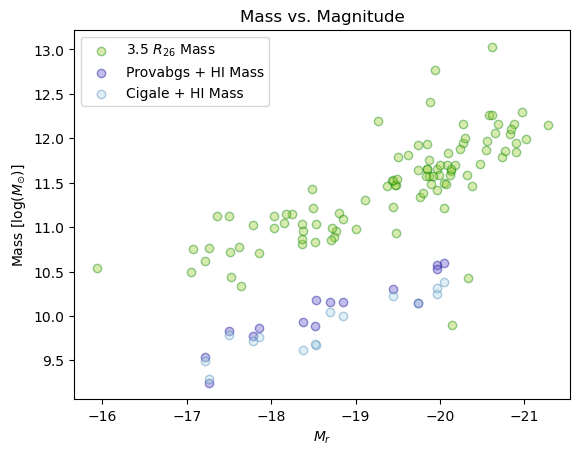

In [8]:
#total mass vs. stellar + H1 mass plotting each mass only once
#plotting
x = sgas['RABS_MAG26']
y = sgas['M_3P5R26']
w = sgas['M_VIS_CIGALE']
z = sgas['M_VIS_PROVABGS']

#plot
plt.scatter(x, y, marker='o', color='yellowgreen', alpha = 0.4, edgecolors = 'green', label = '3.5 $R_{26}$ Mass')
plt.scatter(x, z, marker='o', color='slateblue', alpha = 0.4, edgecolors = 'darkblue', label = 'Provabgs + HI Mass')
plt.scatter(x, w, marker='o', color='lightblue', alpha = 0.4, edgecolors = 'steelblue', label = 'Cigale + HI Mass')
plt.gca().invert_xaxis()
plt.ylabel(r"Mass [$\log(M_{\odot})$]")
plt.xlabel(r"$M_{r}$")
plt.title("Mass vs. Magnitude")
plt.legend()
plt.savefig(v_dir + 'both_vis_3p5total.png', dpi=300)

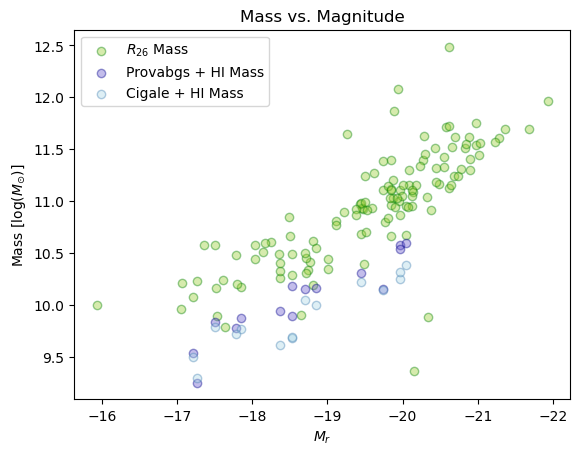

In [9]:
#total mass vs. stellar + H1 mass plotting each mass only once
#plotting
x = sgas['RABS_MAG26']
y = sgas['M_R26']
w = sgas['M_VIS_CIGALE']
z = sgas['M_VIS_PROVABGS']

#plot
plt.scatter(x, y, marker='o', color='yellowgreen', alpha = 0.4, edgecolors = 'green', label = '$R_{26}$ Mass')
plt.scatter(x, z, marker='o', color='slateblue', alpha = 0.4, edgecolors = 'darkblue', label = 'Provabgs + HI Mass')
plt.scatter(x, w, marker='o', color='lightblue', alpha = 0.4, edgecolors = 'steelblue', label = 'Cigale + HI Mass')
plt.gca().invert_xaxis()
plt.ylabel(r"Mass [$\log(M_{\odot})$]")
plt.xlabel(r"$M_{r}$")
plt.title("Mass vs. Magnitude")
plt.legend()
plt.savefig(v_dir + 'both_vis_total.png', dpi=300)

/tmp/ipykernel_380942/1645017391.py:7: RuntimeWarning: divide by zero encountered in log
  ratio_c = 10 ** (np.log(m_vis_cigale) - np.log(m_tot))
/tmp/ipykernel_380942/1645017391.py:8: RuntimeWarning: divide by zero encountered in log
  ratio_p = 10 ** (np.log(m_vis_provabgs) - np.log(m_tot))


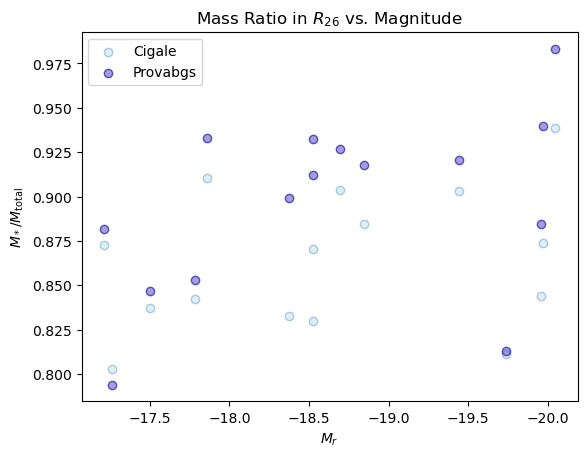

In [10]:
#ratio vis mass to total mass within R26 using cigale and provabgs
m_vis_cigale = sgas['M_VIS_CIGALE']
m_vis_provabgs = sgas['M_VIS_PROVABGS']
mag = sgas['RABS_MAG26']
m_tot = sgas['M_R26']

ratio_c = 10 ** (np.log(m_vis_cigale) - np.log(m_tot))
ratio_p = 10 ** (np.log(m_vis_provabgs) - np.log(m_tot))

#plot
plt.scatter(mag, ratio_c, marker='o', color='lightblue', alpha = 0.4, edgecolors = 'steelblue', label = 'Cigale')
plt.scatter(mag, ratio_p, marker='o', color='slateblue', alpha=0.6, edgecolors='darkblue', label='Provabgs')
plt.gca().invert_xaxis()
#plt.ylim(0.70, 1.10)
#plt.xlim(-15.5, -22.5)
plt.ylabel(r'$M_*/M_{\text{total}}$')
plt.xlabel(r"$M_{r}$")
plt.legend()
plt.title(r"Mass Ratio in $R_{26}$ vs. Magnitude")
plt.savefig(v_dir + 'r26_mass_ratio_plot.png', dpi=300)
plt.show()

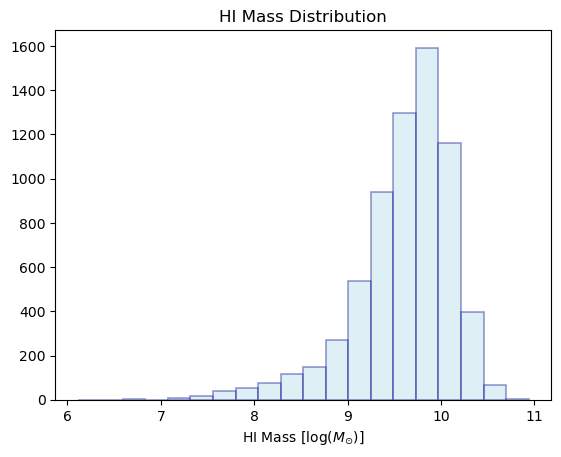

In [11]:
h_1 = sgas['M_HI']

# Plotting
plt.hist(h_1, bins=20,  color='lightblue', alpha = 0.4, edgecolor = 'darkblue', linewidth=1.2, label='Mass Difference')

plt.xlabel(r"HI Mass [$\log(M_{\odot})$]")
plt.title("HI Mass Distribution")
plt.savefig(v_dir + 'histogram_HI.png', dpi=300)
plt.show()

In [12]:
#mask for SGA IDs with valid M_HI, M_STELLAR_CIGALE, and RABS_MAG26 > 0
mask = (sgas['M_HI'] > 0) & (sgas['M_STELLAR_PROVABGS'] >0) & (sgas['M_R26'] > 0) & (sgas['RABS_MAG26'] < 0)

sga_ids_both = sgas['SGA_ID'][mask]

# new table to hold these ids
filtered_rows = np.isin(tf_mastertable['SGA_ID'], sga_ids_both)

filtered_table = tf_mastertable[filtered_rows]

# only use first occurance of each sga id
unique_indices = np.unique(filtered_table['SGA_ID'], return_index=True)[1]

#new table w/ h1 galaxies that will plot
HI_table = filtered_table[unique_indices]

HI_table

TARGETID,TARGET_RA,TARGET_DEC,HEALPIX,SURVEY,Z,ZERR,ZWARN,DELTACHI2,FILENAME,PVTYPE,SGA_ID,RA,DEC,OBS_IN_SV,SKY_FIBER_DIST,SKY_FIBER_DIST_R26,ROT_CURVE,EOA,VELOCITY,VERR,Z_CENTER,ROTCURVE_CHI2,VMAX,VMAX_ERR,RTURN,RTURN_ERR,ALPHA,ALPHA_ERR,INCLINATION,VROT_R26,VROT_R26_ERR,M_R26,M_R26_ERR,VROT_3P5R26,VROT_3P5R26_ERR,M_3P5R26,M_3P5R26_ERR,RABS_MAG26,M_STELLAR_CIGALE,M_STELLAR_CIGALE_ERR,M_STELLAR_PROVABGS,M_STELLAR_PROVABGS_ERR,V_HI,VERR_HI,V20_HI,M_HI,M_HI_ERR,M_VIS_CIGALE,M_VIS_PROVABGS
int64,float64,float64,int64,bytes4,float64,float64,int64,float64,bytes65,bytes3,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1070754149957659,195.07666000858,27.3899059030471,10378,sv3,0.0370459582040079,2.57831123248981e-05,0,22.1116675972007,fuji/healpix/sv3/bright/103/10378/redrock-sv3-bright-10378.fits,TFT,153504,195.0766600085797,27.389905903047108,1.0,0.003223552600095012,0.6700000021781818,1.0,0.0,81.18285039885144,7.794847730455783,0.0367652054621435,20.574870238800802,185.4415505548971,74.96151371718572,0.2995179535186329,0.21553123337745467,1.998238734453617,4.584492304421989,0.5174926642524404,185.34385012817714,478.65927986839426,10.868791033141237,0.7899397603094407,185.43355159251917,744.174208590522,11.413279349617717,0.9555105686088048,-19.96890168354153,10.06378960244879,0.09355638131823035,10.500802993774414,0.25589702345200577,107.0,19.0,143.0,9.79,0.05,10.249152139811203,10.57803432897152
1070144231047169,182.996602641357,1.3554271303175,26287,sv3,0.021166195397418,1.17524527848069e-05,0,53.0657218741253,fuji/healpix/sv3/bright/262/26287/redrock-sv3-bright-26287.fits,TFT,450566,182.99660264135662,1.3554271303175023,1.0,0.0057083455123580745,0.6699999964796225,1.0,0.0,111.1438714900351,3.590306570337229,0.020787752578849066,201.9966155264836,127.61642194928446,30.70013384936726,0.45414373294833826,0.02547103799399365,2.720641501222461,3.228095198969195,1.1362992442412503,127.60360454692805,127.60461382671201,10.545106602792702,0.4771235447463251,127.61599765773553,196.0548590425844,11.089259002099963,0.6098690860184046,-18.848314778852824,9.485600624712717,0.09181581230986238,9.875520706176758,0.10607601275765748,233.0,9.0,252.0,9.84,0.05,9.999019937427141,10.159153399947334
1070161813569541,150.808552610137,1.89329713188126,27256,sv3,0.0457471793198366,1.47267203948601e-05,0,98.4461167193949,fuji/healpix/sv3/bright/272/27256/redrock-sv3-bright-27256.fits,TFT,630029,150.80855261013696,1.8932971318812608,1.0,0.002996700250507625,0.6700000140817963,1.0,0.0,69.20018905743039,4.502679849565004,0.0455058483575779,0.006164998892033873,137.42496303784725,437.7747874772801,0.12042284406714257,5.40981626933579,1.4062222030088223,47.86471553798232,0.5647438077719387,137.2463369593441,7843.501417416986,10.668774971889453,2.0618223506348947,137.39424262052594,12035.112441899233,11.213778560707363,2.2459835433130486,-20.046024483187622,10.187298302694414,0.11966939371017893,10.484847068786621,0.17317799536898487,140.0,14.0,176.0,9.93,0.06,10.378461414072436,10.591619213131887
1070211100835843,210.434250814379,3.96324063920887,26082,sv3,0.0346301674408883,1.31917558077438e-05,0,138.114292503335,fuji/healpix/sv3/bright/260/26082/redrock-sv3-bright-26082.fits,TFT,643231,210.43425081437908,3.96324063920887,1.0,0.0014706588234538055,0.32999999656793844,1.0,0.0,-57.242528238182544,3.998289110298045,0.0348277579925442,117.26821059763721,88.44041353417722,28.30886229599167,0.2555107611722479,0.31462679979066804,1.876243810785266,4.085000365230716,1.1759200524496205,88.36890801673839,216.10017098524568,10.168660224502899,0.7701790223593914,88.4335902686452,344.58788291683203,10.713363806169806,0.9441442202632118,-17.85636538207445,9.126355390188099,0.14275784796359173,9.464704513549805,0

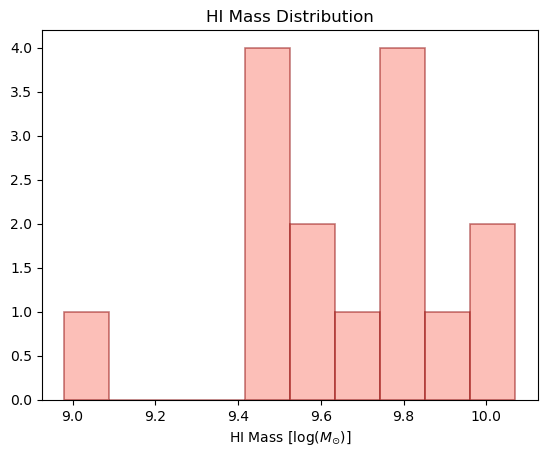

In [13]:
h_1 = HI_table['M_HI']

# plot!
plt.hist(h_1, bins=10,  color='salmon', alpha=0.5, 
         edgecolor='darkred', linewidth=1.2, label='Mass Difference')

plt.xlabel(r"HI Mass [$\log(M_{\odot})$]")
plt.title("HI Mass Distribution")
#plt.savefig(v_dir + 'histogram_HI.png', dpi=300)
plt.show()

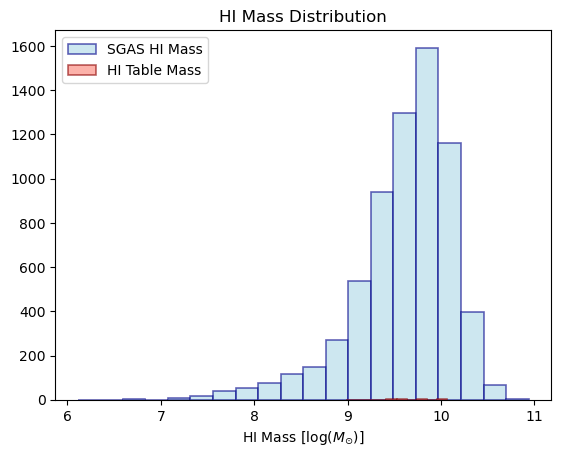

In [14]:
h_1_sgas = sgas['M_HI']
h_1_HI_table = HI_table['M_HI']

# Plotting both histograms
plt.hist(h_1_sgas, bins=20, color='lightblue', alpha=0.6, 
         edgecolor='darkblue', linewidth=1.2, label='SGAS HI Mass')
plt.hist(h_1_HI_table, bins=10, color='salmon', alpha=0.6, 
         edgecolor='darkred', linewidth=1.2, label='HI Table Mass')

# Adding labels and title
plt.xlabel(r"HI Mass [$\log(M_{\odot})$]")
plt.title("HI Mass Distribution")

# Adding legend
plt.legend()

# Save the figure
#plt.savefig(v_dir + 'histogram_HI_overlay.png', dpi=300)

# Show the plot
plt.show()

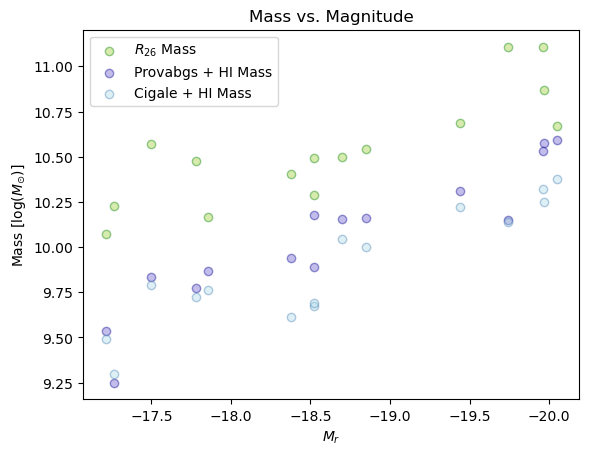

In [15]:
#total mass vs. stellar + H1 mass plotting each mass only once
#plotting
x = HI_table['RABS_MAG26']
y = HI_table['M_R26']
w = HI_table['M_VIS_CIGALE']
z = HI_table['M_VIS_PROVABGS']

#plot
plt.scatter(x, y, marker='o', color='yellowgreen', alpha = 0.4, edgecolors = 'green', label = '$R_{26}$ Mass')
plt.scatter(x, z, marker='o', color='slateblue', alpha = 0.4, edgecolors = 'darkblue', label = 'Provabgs + HI Mass')
plt.scatter(x, w, marker='o', color='lightblue', alpha = 0.4, edgecolors = 'steelblue', label = 'Cigale + HI Mass')
plt.gca().invert_xaxis()
plt.ylabel(r"Mass [$\log(M_{\odot})$]")
plt.xlabel(r"$M_{r}$")
plt.title("Mass vs. Magnitude")
plt.legend()
#plt.savefig(v_dir + 'both_vis_total.png', dpi=300)

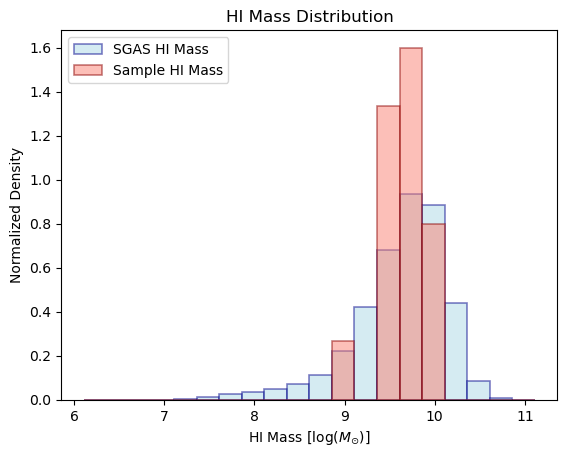

In [16]:
h1_sgas = sgas['M_HI']
h1_sample = HI_table['M_HI']

# define range
min_value = min(h1_sgas.min(), h1_sample.min())
max_value = max(h1_sgas.max(), h1_sample.max())

# define bin width
bin_width = 0.25
bins = np.arange(min_value, max_value + bin_width, bin_width)

# plot!
plt.hist(h1_sgas, bins=bins, color='lightblue', alpha=0.5, 
         edgecolor='darkblue', linewidth=1.2, label='SGAS HI Mass', density=True)

plt.hist(h1_sample, bins=bins, color='salmon', alpha=0.5, 
         edgecolor='darkred', linewidth=1.2, label='Sample HI Mass', density=True)

plt.xlabel(r"HI Mass [$\log(M_{\odot})$]")
plt.ylabel('Normalized Density')
plt.title("HI Mass Distribution")
plt.legend()

plt.savefig(v_dir + 'histogram_HI_overlay.png', dpi=300)

plt.show()

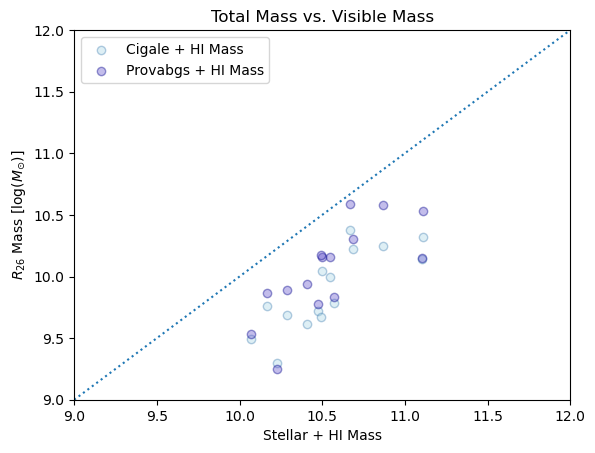

In [17]:
#total mass vs. stellar + H1 mass plotting each mass only once
#plotting
x = sgas['M_R26']
y = sgas['M_VIS_CIGALE']
z = sgas['M_VIS_PROVABGS']

#plot
plt.scatter(x, y, marker='o', color='lightblue', alpha = 0.4, edgecolors = 'steelblue', label = 'Cigale + HI Mass')
plt.scatter(x, z, color='slateblue', alpha = 0.4, edgecolors = 'darkblue', label = 'Provabgs + HI Mass')

plt.plot([9, 12], [9, 12], ls = ':')

plt.ylim(9, 12)
plt.xlim(9, 12)

plt.ylabel(r"$R_{26}$ Mass [$\log(M_{\odot})$]")
plt.xlabel("Stellar + HI Mass")
plt.title("Total Mass vs. Visible Mass")
plt.legend()
plt.savefig(v_dir + 'vis_total.png', dpi=300)

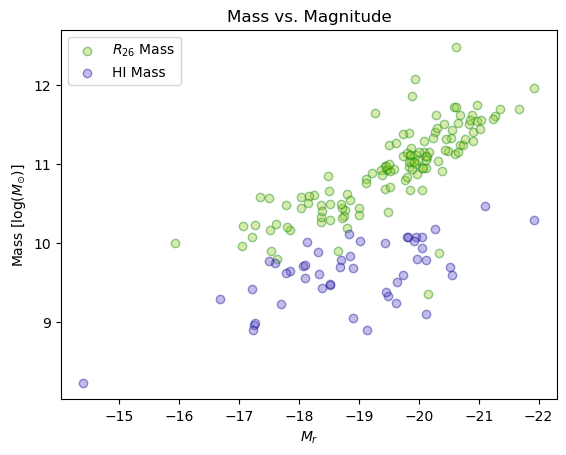

In [18]:
#total mass vs. stellar + H1 mass plotting each mass only once
#plotting
x = sgas['RABS_MAG26']
y = sgas['M_R26']
w = sgas['M_HI']

#plot
plt.scatter(x, y, marker='o', color='yellowgreen', alpha = 0.4, edgecolors = 'green', label = '$R_{26}$ Mass')
plt.scatter(x, w, marker='o', color='slateblue', alpha = 0.4, edgecolors = 'darkblue', label = 'HI Mass')

plt.gca().invert_xaxis()
plt.ylabel(r"Mass [$\log(M_{\odot})$]")
plt.xlabel(r"$M_{r}$")
plt.title("Mass vs. Magnitude")
plt.legend()
plt.savefig(v_dir + 'both_vis_total.png', dpi=300)

In [ ]:
#writing new data into new table
tf_mastertable.write(data_dir + 'tf_mastertable_massmag_H1_stellar.fits', format='fits', overwrite=True)